### Packages and Functions

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch
import scipy
from scipy.stats import wasserstein_distance

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist
import plot_loss
from torch import optim
from tqdm.notebook import trange

from sklearn.preprocessing import StandardScaler

import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [4]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

def build_flow(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes = 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

def build_flow_gauss(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=DiagNormal,
                      univariate_kwargs={"bound": 10},
                      passes= 2 if not autoregressive else features)
    return flow

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Dataset

In [5]:
#Preparing the dataset
df = ak.from_parquet("all_jets_v6.parquet")

(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

initial_pz = 6500*(generator_info.x1 - generator_info.x2)
initial_E = 6500*(generator_info.x1 + generator_info.x2)

initial_boost = ak.Array(
    {"px": np.zeros_like(initial_pz), "py": np.zeros_like(initial_pz), "pz": initial_pz, "E": initial_E},
    with_name="Momentum4D"
)

#Converting to torch
#Column 1 is pz, column 2 is E
y_cond = np.stack( [ 
    ak.to_numpy(boost_reco.pz, allow_missing=None),
    ak.to_numpy(boost_reco.E, allow_missing=None)]).T

#Rescaling
scaler = StandardScaler()

Y_scaled = torch.from_numpy(scaler.fit_transform(y_cond)).float()

x_target = np.stack( [ 
    ak.to_numpy(generator_info.x1, allow_missing=None),
    ak.to_numpy(generator_info.x2, allow_missing=None)]).T

x_target_torch = torch.from_numpy(x_target).float()

# transform it to pz and E
X = torch.zeros_like(x_target_torch)
X[:,0] = 6500*(x_target_torch[:,0]-x_target_torch[:,1])
X[:,1] = 6500*(x_target_torch[:,0]+x_target_torch[:,1])


X_scaled = torch.from_numpy(scaler.transform(X)).float()

### Training Loop

In [49]:
nepochs = 50
batch_size = 2048
lr_init = 0.0001
N_training_samples = len(Y_scaled)

flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32], bins=10, autoregressive=True)
flow = flow.to("cuda")
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

X_scaled = X_scaled.to("cuda")
Y_scaled = Y_scaled.to("cuda")

for e in trange(0, nepochs, desc="Epoch"):
    
    permutation = torch.randperm(N_training_samples).to("cuda")
    t = trange(0, N_training_samples, batch_size, desc="Batch")
    for i in t:
            
        indices = permutation[i:i+batch_size]
        
        optimizer.zero_grad()

        logp_g =  flow(Y_scaled[indices]).log_prob(X_scaled[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     

        if i % (batch_size *20) == 0:
            t.set_description(f"{loss.item():.4f}", refresh=True)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

In [50]:
flow = flow.cpu()
X_scaled = X_scaled.cpu()
Y_scaled = Y_scaled.cpu()

### Slice Analysis

In [16]:
#TODO: Package it all into a function that takes flow as input, clean everything up
#TODO: Investigate Frobenius norm and Wasserstein distance
#TODO: Git stuff

In [8]:
#Q: Loss function?
#Q: Project registration mystudies?

#features = target, context = conditioning, transforms = layers of bijections, bins = spline nodes, 
# hidden_features = neural network nodes
# autoregressive vs. coupling: autoregressive more expensive, but more expressive (correlation between dimensions)

In [51]:
def select_segments(y, x, pz_range, E_range):
    mask = (y > [pz_range[0], E_range[0]]) & (y < [pz_range[1], E_range[1]])
    mask = mask[:,0]*mask[:,1]
    return y[mask], x[mask]

def compare(y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] == 0:
        return None
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    print(len(X_select_scaled[:,0].numpy()), len(out[:,0].numpy()))
    
    plt.hist(X_select_scaled[:,0].numpy(), bins=30, histtype="step", label="target", range=(-5, 5))
    plt.hist(out[:,0].numpy(), bins=30, histtype="step", label="generated", range=(-5, 5))
    plt.legend()
    plt.title("pz")
    plt.show()
    
    plt.hist(X_select_scaled[:,1].numpy(), bins=30, histtype="step", label="target", range=(-5, 10))
    plt.hist(out[:,1].numpy(), bins=30, histtype="step", label="generated", range=(-5, 10))
    plt.legend()
    plt.title("E")
    plt.show()
    
    g_pz = scipy.stats.kstest(X_select_scaled[:,0].numpy(), out[:,0].numpy())
    print(g_pz)
    return 0

def goodness(input_flow, y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] < 100:
        return (None, None)
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = input_flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    pz_goodness = scipy.stats.kstest(X_select_scaled[:,0].numpy(), out[:,0].numpy()).statistic
    E_goodness = scipy.stats.kstest(X_select_scaled[:,1].numpy(), out[:,1].numpy()).statistic
    
    return (pz_goodness, E_goodness)
    
    

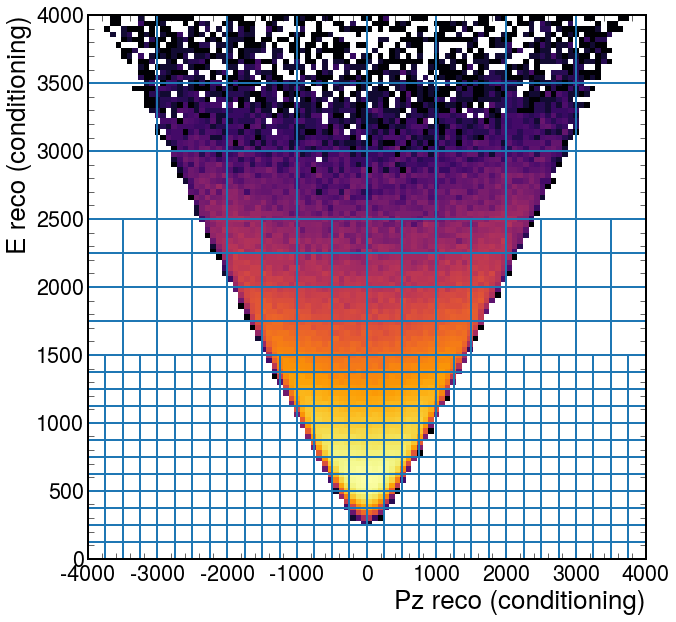

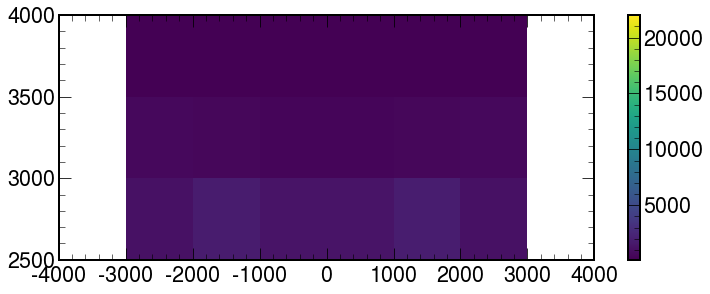

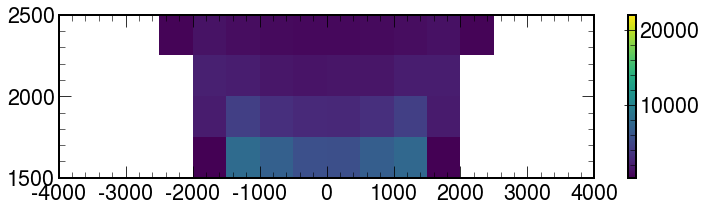

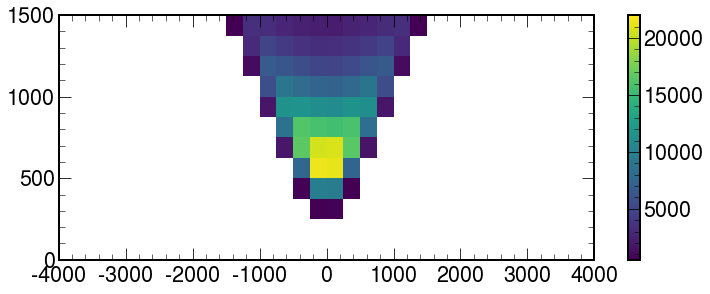

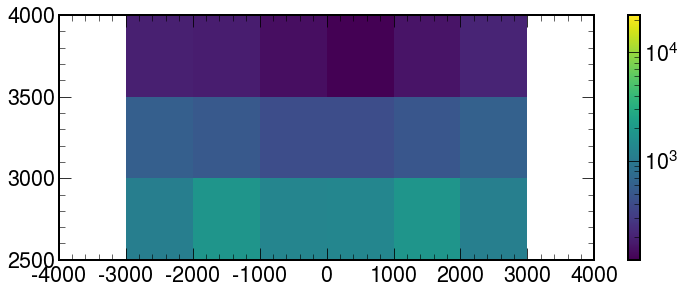

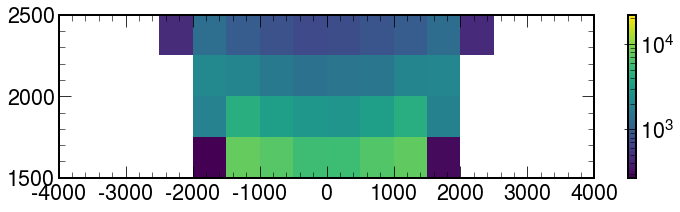

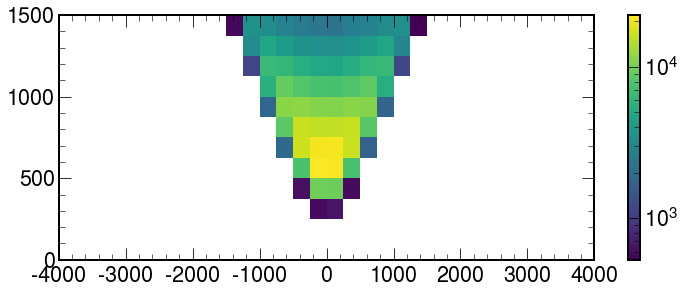

In [52]:
#Dividing reco space

pz_range = [-4000, 4000]
E_range = [0, 1500, 2500, 4000]

seg1_pz = np.linspace(pz_range[0], pz_range[1], 33)
seg1_E = np.linspace(E_range[0], E_range[1], 13)
seg2_pz = np.linspace(pz_range[0], pz_range[1], 17)
seg2_E = np.linspace(E_range[1], E_range[2], 5)
seg3_pz = np.linspace(pz_range[0], pz_range[1], 9)
seg3_E = np.linspace(E_range[2], E_range[3], 4)

plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[100,100], range=[[-4000, 4000], [0,4000]], cmap="inferno", cmin=1, norm=LogNorm())

for i in seg1_pz:
    plt.vlines(seg1_pz, E_range[0], E_range[1])
    plt.hlines(seg1_E, pz_range[0], pz_range[1])
for i in seg2_pz:
    plt.vlines(seg2_pz, E_range[1], E_range[2])
    plt.hlines(seg2_E, pz_range[0], pz_range[1])
for i in seg1_pz:
    plt.vlines(seg3_pz, E_range[2], E_range[3])
    plt.hlines(seg3_E, pz_range[0], pz_range[1])
plt.xlabel("Pz reco (conditioning)")
plt.ylabel("E reco (conditioning)")

plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg3_pz, seg3_E], range=[pz_range, [E_range[2], E_range[3]]], cmap="viridis", cmin=100,  norm=Normalize(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg2_pz, seg2_E], range=[pz_range, [E_range[1], E_range[2]]], cmap="viridis", cmin=100,  norm=Normalize(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg1_pz, seg1_E], range=[pz_range, [E_range[0], E_range[1]]], cmap="viridis", cmin=100, norm=Normalize(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg3_pz, seg3_E], range=[pz_range, [E_range[2], E_range[3]]], cmap="viridis", cmin=100,  norm=LogNorm(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg2_pz, seg2_E], range=[pz_range, [E_range[1], E_range[2]]], cmap="viridis", cmin=100,  norm=LogNorm(vmax=22000))
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4.5))
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[seg1_pz, seg1_E], range=[pz_range, [E_range[0], E_range[1]]], cmap="viridis", cmin=100, norm=LogNorm(vmax=22000))
plt.colorbar()
plt.show()

### Frobenius Norm of Pearson Correlation Matrix

In [99]:
#returns pearson correlation matrix for a 2D array
def pearson_matrix(a):
    off_diag = scipy.stats.pearsonr(a[:,0], a[:,1])[0]
    return np.array([[1, off_diag], [off_diag, 1]])
    

def F_distance(a1, a2):
    if len(a1) != len(a2): raise Exception("array dimensions don't match.")
    M = pearson_matrix(a1) - pearson_matrix(a2)
    return np.linalg.norm(M, ord="fro")
    

def F_goodness(input_flow, y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] < 100:
        return None
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = input_flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    Fgoodness = F_distance(X_select_scaled.numpy(), out.numpy())
    return Fgoodness

def gen_Fg_matrix(input_flow, y, x, seg_pz, seg_E):
    n_pz = len(seg_pz)-1
    n_E = len(seg_E)-1
    Fg_matrix = np.zeros((n_E, n_pz))

    for i in range(n_pz):
        for j in range(n_E):
            Fgoodness = F_goodness(input_flow, y, x, [seg_pz[i], seg_pz[i+1]], [seg_E[j], seg_E[j+1]])
            Fg_matrix[n_E-j-1, i] = Fgoodness
    print("matrix generated.")
    return Fg_matrix

In [53]:
Fg_matrix3 = gen_Fg_matrix(flow, y_cond, X, seg3_pz, seg3_E)
Fg_matrix2 = gen_Fg_matrix(flow, y_cond, X, seg2_pz, seg2_E)
Fg_matrix1 = gen_Fg_matrix(flow, y_cond, X, seg1_pz, seg1_E)

matrix generated.
matrix generated.
matrix generated.


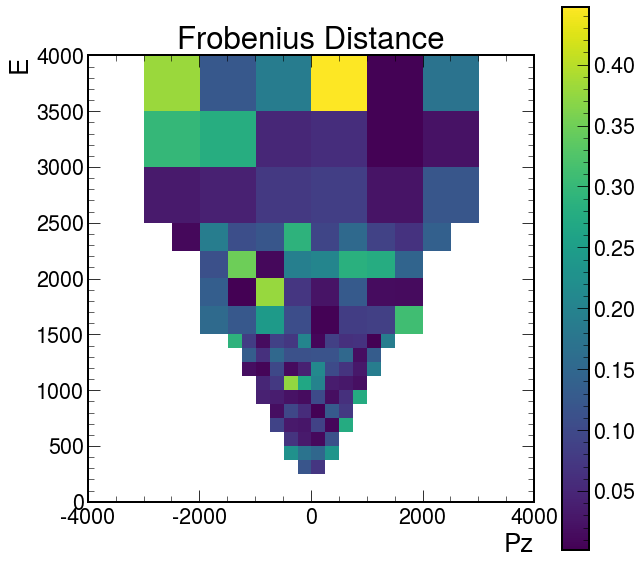

In [100]:
widemat2 = np.repeat(Fg_matrix2, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(Fg_matrix3, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

Fg_matrix = np.concatenate([widemat3, widemat2, Fg_matrix1])

plt.imshow(Fg_matrix, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("Frobenius Distance")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

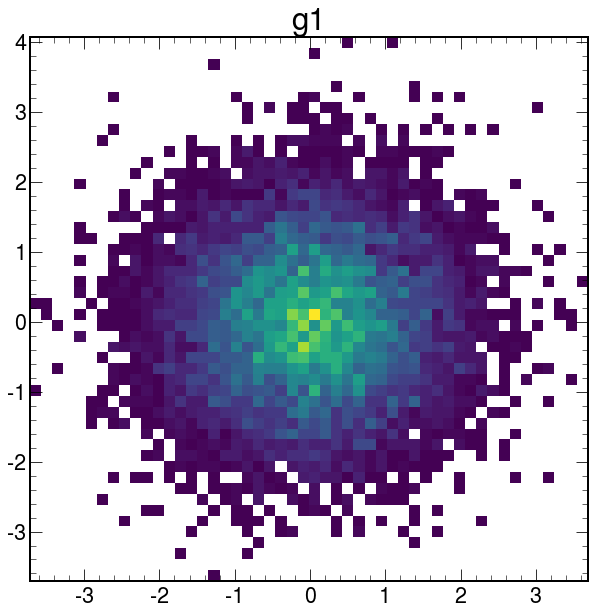

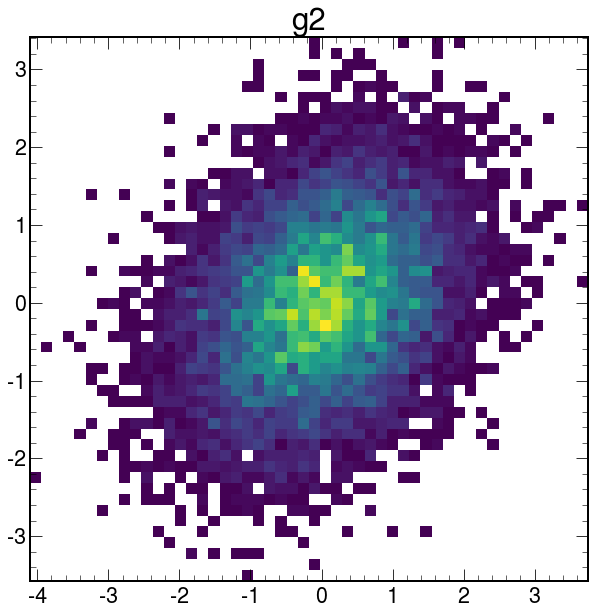

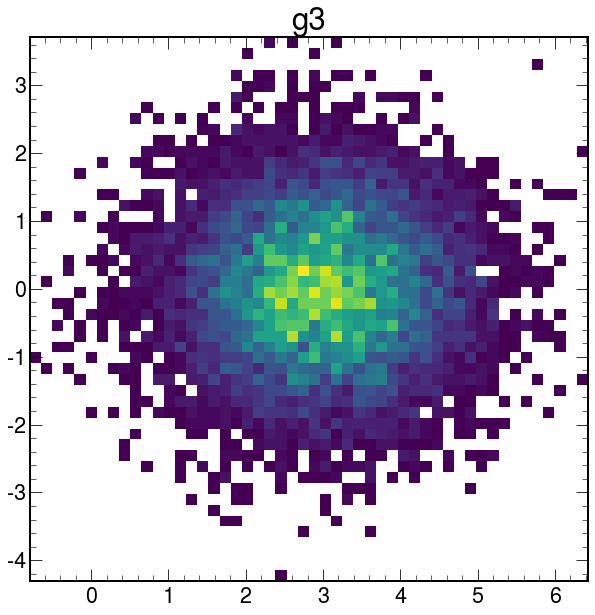

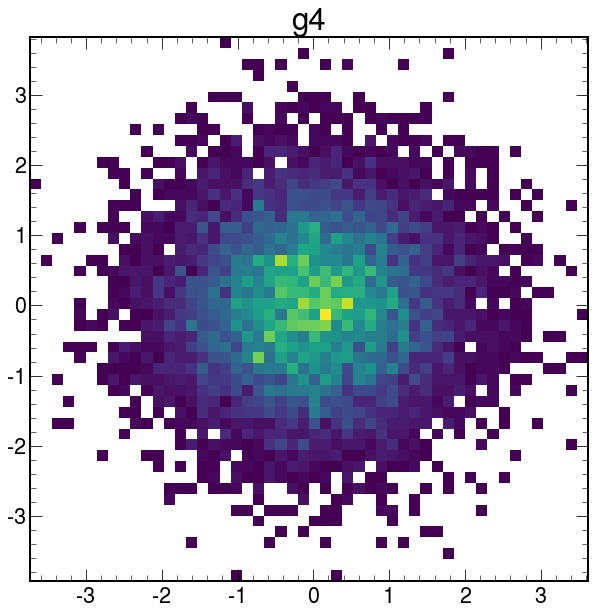

NameError: name 'F_distance' is not defined

In [2]:
g1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10000)
g2 = np.random.multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]], 10000)
g3 = np.random.multivariate_normal([3, 0], [[1, 0], [0, 1]], 10000)
g4 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10000)


plt.hist2d(g1[:,0], g1[:,1], bins=50, cmin=1)
plt.title("g1")
plt.show()

plt.hist2d(g2[:,0], g2[:,1], bins=50, cmin=1)
plt.title("g2")
plt.show()

plt.hist2d(g3[:,0], g3[:,1], bins=50, cmin=1)
plt.title("g3")
plt.show()

plt.hist2d(g4[:,0], g4[:,1], bins=50, cmin=1)
plt.title("g4")
plt.show()

print("F-distance g1, g2:", F_distance(g1, g2))
print("F-distance g1, g3:", F_distance(g1, g3))
print("F-distance g1, g4:", F_distance(g1, g4))


### Bhattacharyya Distance

In [128]:
#the first array determines the range of the histogram
def b_distance(a1, a2):
    xmin = np.min(a1[:,0]); ymin = np.min(a1[:,1])
    xmax = np.max(a1[:,0]); ymax = np.max(a1[:,1])

    a1_distr = np.histogram2d(a1[:,0], a1[:,1], range=[[xmin, xmax], [ymin, ymax]], bins=int(np.sqrt(len(a1)*0.1)))[0] / len(a1)
    a2_distr = np.histogram2d(a2[:,0], a2[:,1], range=[[xmin, xmax], [ymin, ymax]], bins=int(np.sqrt(len(a2)*0.1)))[0] / len(a2)
    
    b_coeff = np.sum(np.sqrt(a1_distr*a2_distr))
    return -np.log(b_coeff)

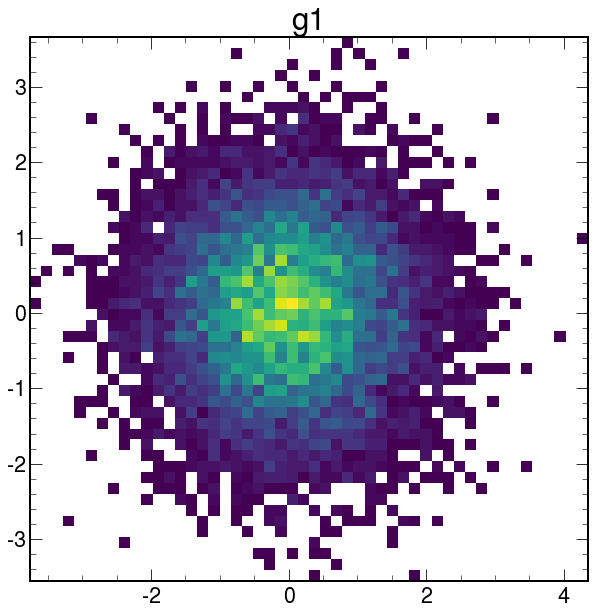

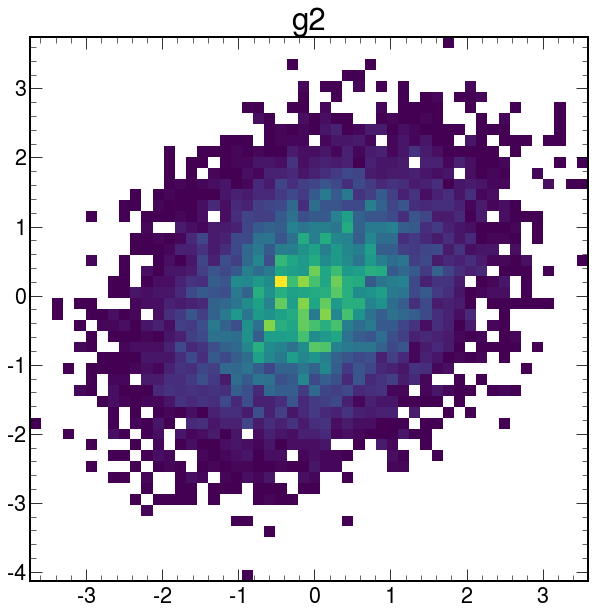

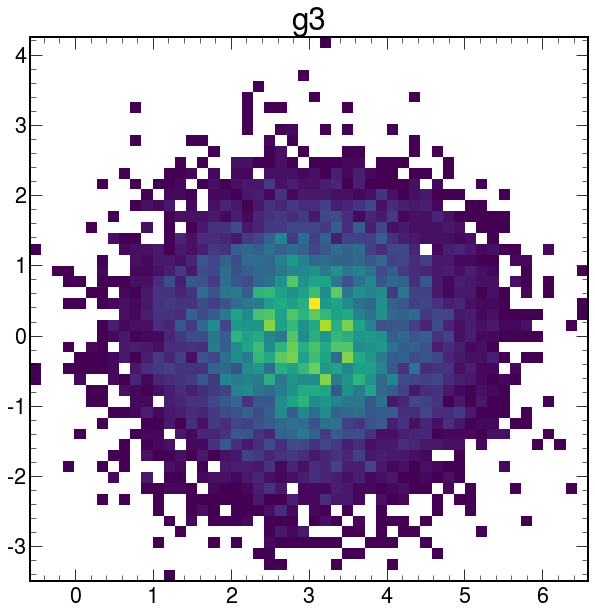

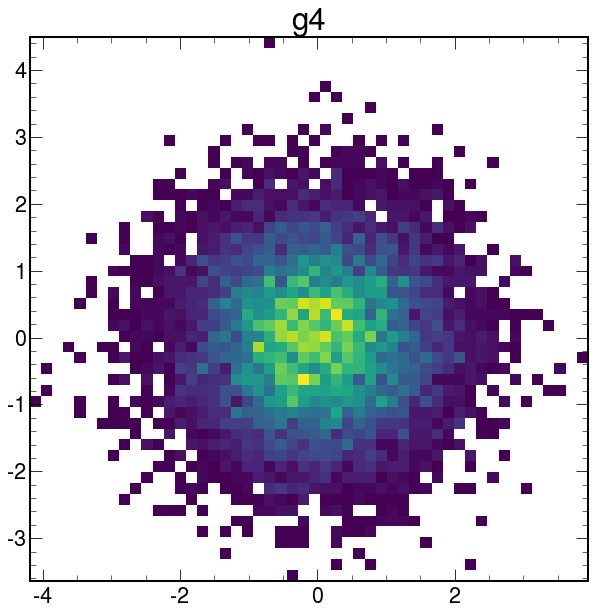

B-distance g1, g2: 0.033963293008579545
B-distance g1, g3: 1.2388993203383354
B-distance g1, g4: 0.017111918290302012


In [122]:
g1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10000)
g2 = np.random.multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]], 10000)
g3 = np.random.multivariate_normal([3, 0], [[1, 0], [0, 1]], 10000)
g4 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10000)


plt.hist2d(g1[:,0], g1[:,1], bins=50, cmin=1)
plt.title("g1")
plt.show()

plt.hist2d(g2[:,0], g2[:,1], bins=50, cmin=1)
plt.title("g2")
plt.show()

plt.hist2d(g3[:,0], g3[:,1], bins=50, cmin=1)
plt.title("g3")
plt.show()

plt.hist2d(g4[:,0], g4[:,1], bins=50, cmin=1)
plt.title("g4")
plt.show()

print("B-distance g1, g2:", b_distance(g1, g2))
print("B-distance g1, g3:", b_distance(g1, g3))
print("B-distance g1, g4:", b_distance(g1, g4))


In [123]:
def b_goodness(input_flow, y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] < 100:
        return None
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = input_flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    bgoodness = b_distance(X_select_scaled.numpy(), out.numpy())
    return bgoodness

In [124]:
def gen_bg_matrix(input_flow, y, x, seg_pz, seg_E):
    n_pz = len(seg_pz)-1
    n_E = len(seg_E)-1
    bg_matrix = np.zeros((n_E, n_pz))

    for i in range(n_pz):
        for j in range(n_E):
            bgoodness = b_goodness(input_flow, y, x, [seg_pz[i], seg_pz[i+1]], [seg_E[j], seg_E[j+1]])
            bg_matrix[n_E-j-1, i] = bgoodness
    print("matrix generated.")
    return bg_matrix

In [137]:
bg_matrix3 = gen_bg_matrix(flow, y_cond, X, seg3_pz, seg3_E)
bg_matrix2 = gen_bg_matrix(flow, y_cond, X, seg2_pz, seg2_E)
bg_matrix1 = gen_bg_matrix(flow, y_cond, X, seg1_pz, seg1_E)


matrix generated.
matrix generated.
matrix generated.


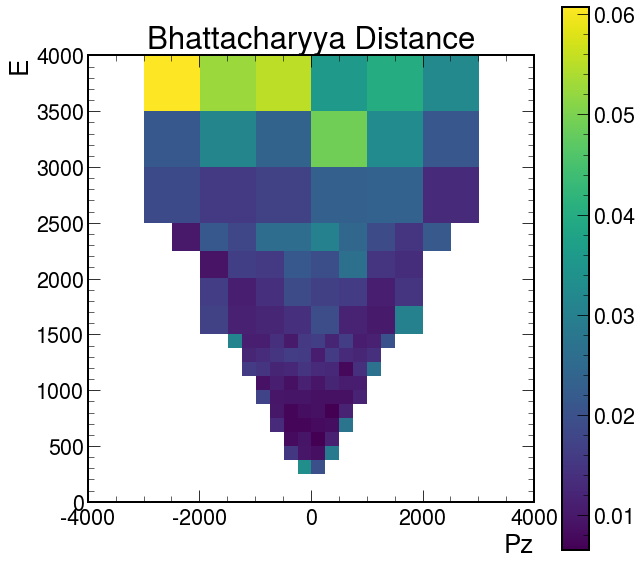

In [139]:
widemat2 = np.repeat(bg_matrix2, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(bg_matrix3, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

bg_matrix = np.concatenate([widemat3, widemat2, bg_matrix1])

plt.imshow(bg_matrix, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0)
plt.title("Bhattacharyya Distance")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

### Splitting Dataset: Training and Validation

In [95]:
half = int(len(Y_scaled)/2)
Y_scaled_train = Y_scaled[:half]
Y_val = y_cond[half:]

X_scaled_train = X_scaled[:half]
X_val = X[half:]

In [96]:
nepochs = 50
batch_size = 2048
lr_init = 0.0001
N_training_samples = len(Y_scaled_train)

val_flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32], bins=10, autoregressive=True)
val_flow = val_flow.to("cuda")
optimizer = optim.Adam(val_flow.parameters(), lr=lr_init)

X_scaled_train = X_scaled_train.to("cuda")
Y_scaled_train = Y_scaled_train.to("cuda")

for e in trange(0, nepochs, desc="Epoch"):
    
    permutation = torch.randperm(N_training_samples).to("cuda")
    t = trange(0, N_training_samples, batch_size, desc="Batch")
    for i in t:
            
        indices = permutation[i:i+batch_size]
        
        optimizer.zero_grad()

        logp_g =  val_flow(Y_scaled_train[indices]).log_prob(X_scaled_train[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     

        if i % (batch_size *20) == 0:
            t.set_description(f"{loss.item():.4f}", refresh=True)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Batch:   0%|          | 0/143 [00:00<?, ?it/s]

In [105]:
val_flow = val_flow.cpu()

In [131]:
valFg_matrix3 = gen_Fg_matrix(val_flow, Y_val, X_val, seg3_pz, seg3_E)
valFg_matrix2 = gen_Fg_matrix(val_flow, Y_val, X_val, seg2_pz, seg2_E)
valFg_matrix1 = gen_Fg_matrix(val_flow, Y_val, X_val, seg1_pz, seg1_E)

matrix generated.
matrix generated.
matrix generated.


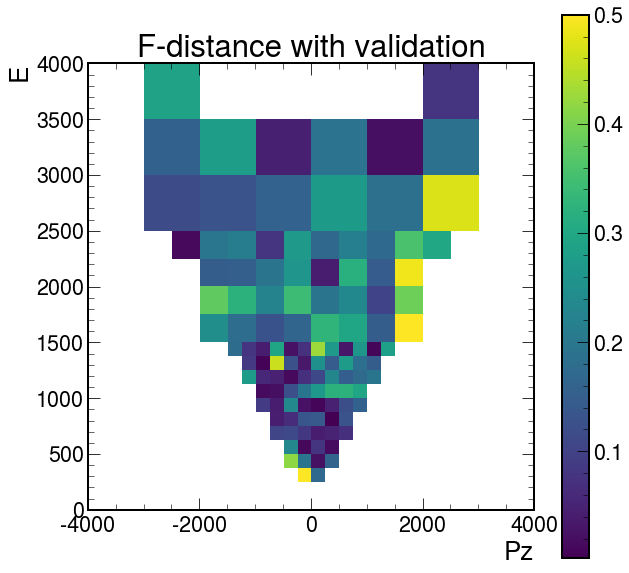

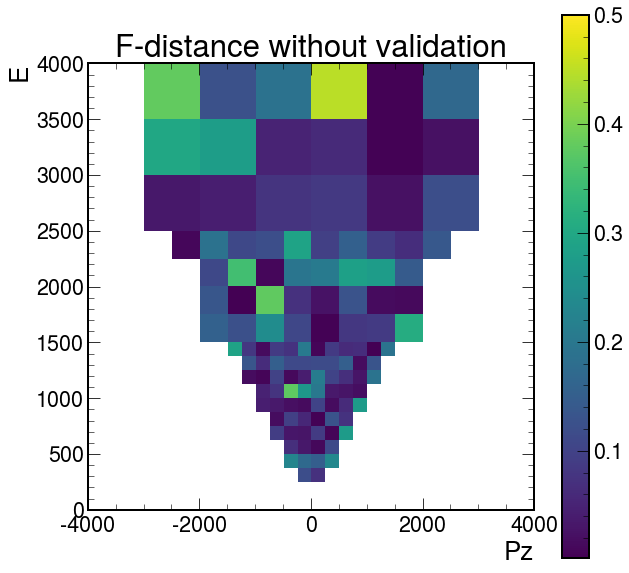

In [142]:
widemat2 = np.repeat(valFg_matrix2, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(valFg_matrix3, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

valFg_matrix = np.concatenate([widemat3, widemat2, valFg_matrix1])

plt.imshow(valFg_matrix, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.5))
plt.title("F-distance with validation")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

plt.imshow(Fg_matrix, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.5))
plt.title("F-distance without validation")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

In [135]:
valbg_matrix3 = gen_bg_matrix(val_flow, Y_val, X_val, seg3_pz, seg3_E)
valbg_matrix2 = gen_bg_matrix(val_flow, Y_val, X_val, seg2_pz, seg2_E)
valbg_matrix1 = gen_bg_matrix(val_flow, Y_val, X_val, seg1_pz, seg1_E)

matrix generated.
matrix generated.
matrix generated.


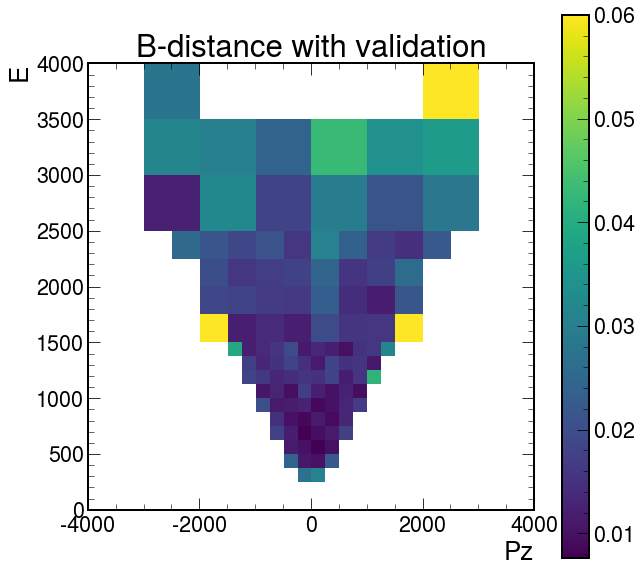

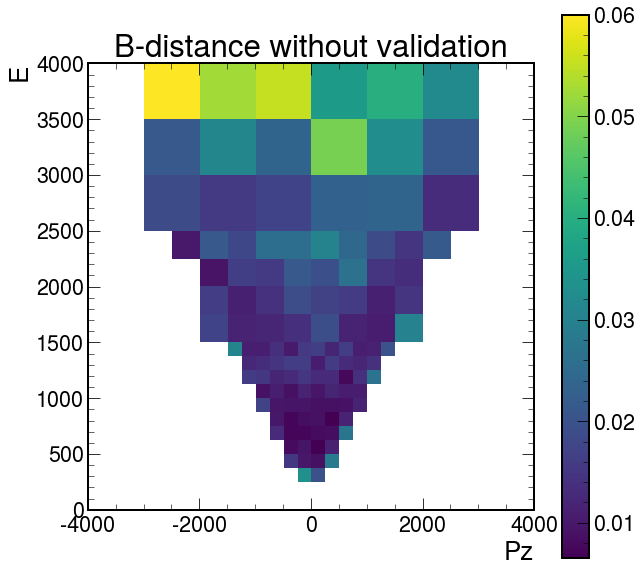

In [144]:
widemat2 = np.repeat(valbg_matrix2, 2, axis=0)
widemat2 = np.repeat(widemat2, 2, axis=1)

widemat3 = np.repeat(valbg_matrix3, 4, axis=0)
widemat3 = np.repeat(widemat3, 4, axis=1)

valbg_matrix = np.concatenate([widemat3, widemat2, valbg_matrix1])

plt.imshow(valbg_matrix, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.06))
plt.title("B-distance with validation")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

plt.imshow(bg_matrix, interpolation='none', extent=[-4000, 4000, 0, 4000], aspect=2.0, norm=Normalize(vmax=0.06))
plt.title("B-distance without validation")
plt.colorbar()
plt.xlabel("Pz"); plt.ylabel("E")
plt.show()

### Varying Flow Parameters